In [21]:
import sqldb
import graph
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
from queue import SimpleQueue as Queue

In [22]:
db: sqlite3.Connection = sqldb.get_db_connection()
cities = np.array(sqldb.get_cities(db))
borders = np.array(sqldb.get_borders(db))

In [23]:
cities_map = {city[0]:city for city in cities}

In [24]:
print("Nb cities:", len(cities))
print("Nb borders:", len(borders))
print("Mean borders/cities:", len(borders)/len(cities))

Nb cities: 38285
Nb borders: 219294
Mean borders/cities: 5.727935222672064


In [25]:
ID_NAME = 1
ID_POPULATION = 4
THRESOLD = graph.Canton.BIG_THRESOLD
populations = np.array(cities[:,4], dtype=np.uint)
big_cities = cities[populations >= THRESOLD]

In [26]:
print("Nb big cities:", len(big_cities))
print("Mean borders/big cities:", len(borders)/len(big_cities))
print("Ratio:", len(big_cities)/len(cities) * 100)

Nb big cities: 141
Mean borders/big cities: 1555.276595744681
Ratio: 0.3682904531800966


In [27]:
borders_map = dict()
for city in cities:
    borders_map.setdefault(city[0], []).append(city[0])
for border in borders:
    borders_map.setdefault(border[0], []).append(border[1])

{'whiskers': [<matplotlib.lines.Line2D at 0xb6c06f0>,
 'caps': [<matplotlib.lines.Line2D at 0xb6c0cf0>,
 'boxes': [<matplotlib.lines.Line2D at 0xb6c06d0>],
 'medians': [<matplotlib.lines.Line2D at 0xb6c7490>],
 'fliers': [<matplotlib.lines.Line2D at 0xb6c76b0>],
 'means': []}

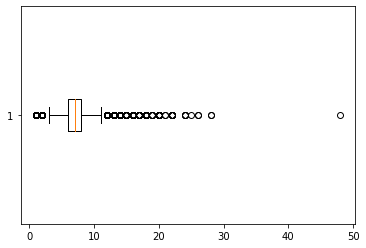

In [28]:
borders_map_count = [len(v) for v in borders_map.values()]
plt.boxplot(borders_map_count, vert=False)

In [29]:
queue = Queue()

for code in big_cities[:,0]:
    queue.put(code)

distances = {k:(0 if k in big_cities[:,0] else -1) for k in cities_map.keys()}

not_found = set()

while not queue.empty():
    city = queue.get()
    cur_dist = distances[city]
    for border_city in borders_map[city]:
        if not border_city in distances.keys():
            not_found.add(border_city)
            continue
        border_dist = distances[border_city]
        if border_dist == -1 or border_dist - cur_dist > 1:
            distances[border_city] = cur_dist + 1
            queue.put(border_city)

In [30]:
cities_map['Q28726684']

array(['Q28726684', 'Annecy', 'Q12751', 'Q18338206', '54074',
       '6.129444444', '45.899166666', '0'], dtype='<U45')

In [31]:
cities[cities[:,0] == 'Q90']

array([], shape=(0, 8), dtype='<U45')

In [32]:
db.execute(''' SELECT * FROM cities where name = 'Q90'; ''').fetchall()

[]

In [33]:
print("Min dist:", min(distances.values()))
print("Max dist:", max(distances.values()))

Min dist: -1
Max dist: 23


In [34]:
missing = [code for code, dist in distances.items() if dist == -1]
missing_cities = [cities_map[code] for code in missing]

In [35]:
cities_map[missing[0]] # https://www.wikidata.org/wiki/Q216908 replaced by https://www.wikidata.org/wiki/Q21027256


array(['Q216908', 'Plœuc-sur-Lié', 'Q3349', 'Q12130', '3308',
       '-2.757777777', '48.346388888', '0'], dtype='<U45')

In [36]:
cities_map['Q21027256']

array(['Q21027256', "Plœuc-L'Hermitage", 'Q3349', 'Q12130', '4062',
       '-2.756388888', '48.346944444', '0'], dtype='<U45')

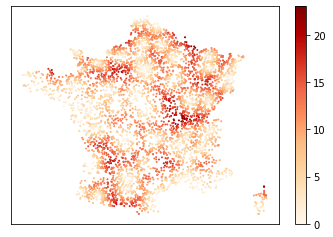

In [37]:
R = 6378.137
def convert3D(u):
    xyz = np.zeros((u.shape[0],3))
    u1 = u[:, 0] * (np.pi / 180)
    v1 = u[:, 1] * (np.pi / 180)
    xyz[:,2] = R * np.cos(u1) * np.sin(v1)
    xyz[:,1] = -R * np.cos(u1) * np.cos(v1)
    xyz[:,0] = R * np.sin(u1)
    return xyz

order = list(distances.keys())
coordinates = np.array([cities_map[o][5:7] for o in order if distances[o] != -1]).astype(np.float32)
dists = np.array([distances[o] for o in order if distances[o] != -1])
xyz = convert3D(coordinates)
dists = dists[xyz[:, 1] > -6000]
xyz = xyz[xyz[:, 1] > -6000]

# Only do it partially, it takes long for a full render
dists = dists[::8]
xyz = xyz[::8]

fig = plt.figure()
ax = fig.gca()
ax.set_yticks([])
ax.set_xticks([])
sc = ax.scatter(xyz[:, 0], xyz[:, 1], s=1, c=dists, cmap="OrRd")
plt.colorbar(sc)
plt.show()

In [41]:
sql = ''' UPDATE cities
              SET distance = ? 
              WHERE code = ?'''
for key in order:
    db.execute(sql, (distances[key], key))
db.commit()


In [58]:
import json

tmp_cities = db.execute("SELECT name, distance FROM cities").fetchall()
tmp_cities_map = {k[0]:k[1] for k in tmp_cities}

with open("firefox_addon/cities_data.json", mode="w", encoding='utf8') as f:
    json.dump(tmp_cities_map, f, ensure_ascii=False)